# Performance Deep Dive: Spark Pipeline Analyse

In diesem Notebook analysieren wir die Ressourcen-Logs (`system_metrics.csv`), die während des Laufs der Spark-Pipeline erstellt wurden.

**Ziele:**
1. Beweis für **True Streaming** (Konstanter RAM trotz Download).
2. Beweis für **Caching** (Kein erneuter Download beim Schreiben).
3. Analyse der **CPU-Auslastung** pro Phase.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Grafik-Style setzen
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 12)

print("Bibliotheken geladen.")

Bibliotheken geladen.


In [2]:
# 1. Daten laden
try:
    df = pd.read_csv("../../data/system_metrics.csv")

    # Zeitstempel in echtes Datetime-Format wandeln
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    print(f"Daten geladen: {len(df)} Messpunkte gefunden.")
    display(df.head()) # Zeigt die ersten 5 Zeilen
except FileNotFoundError:
    print("FEHLER: Datei '../data/system_metrics.csv' nicht gefunden. Prüfe den Pfad!")

Daten geladen: 126 Messpunkte gefunden.


,timestamp,stage,cpu_percent,ram_percent,ram_gb,net_sent_mb,net_recv_mb
0,2026-01-21 22:29:15.951290,1. Setup Spark,44.4,51.5,7.14,0.0,0.00
1,2026-01-21 22:29:16.462581,1. Setup Spark,10.8,51.7,7.17,0.0,0.00
2,2026-01-21 22:29:16.976495,1. Setup Spark,28.2,51.7,7.16,0.0,0.00
3,2026-01-21 22:29:17.489636,1. Setup Spark,25.0,52.0,7.21,0.0,0.01
4,2026-01-21 22:29:17.999391,1. Setup Spark,21.7,52.3,7.26,0.0,0.00


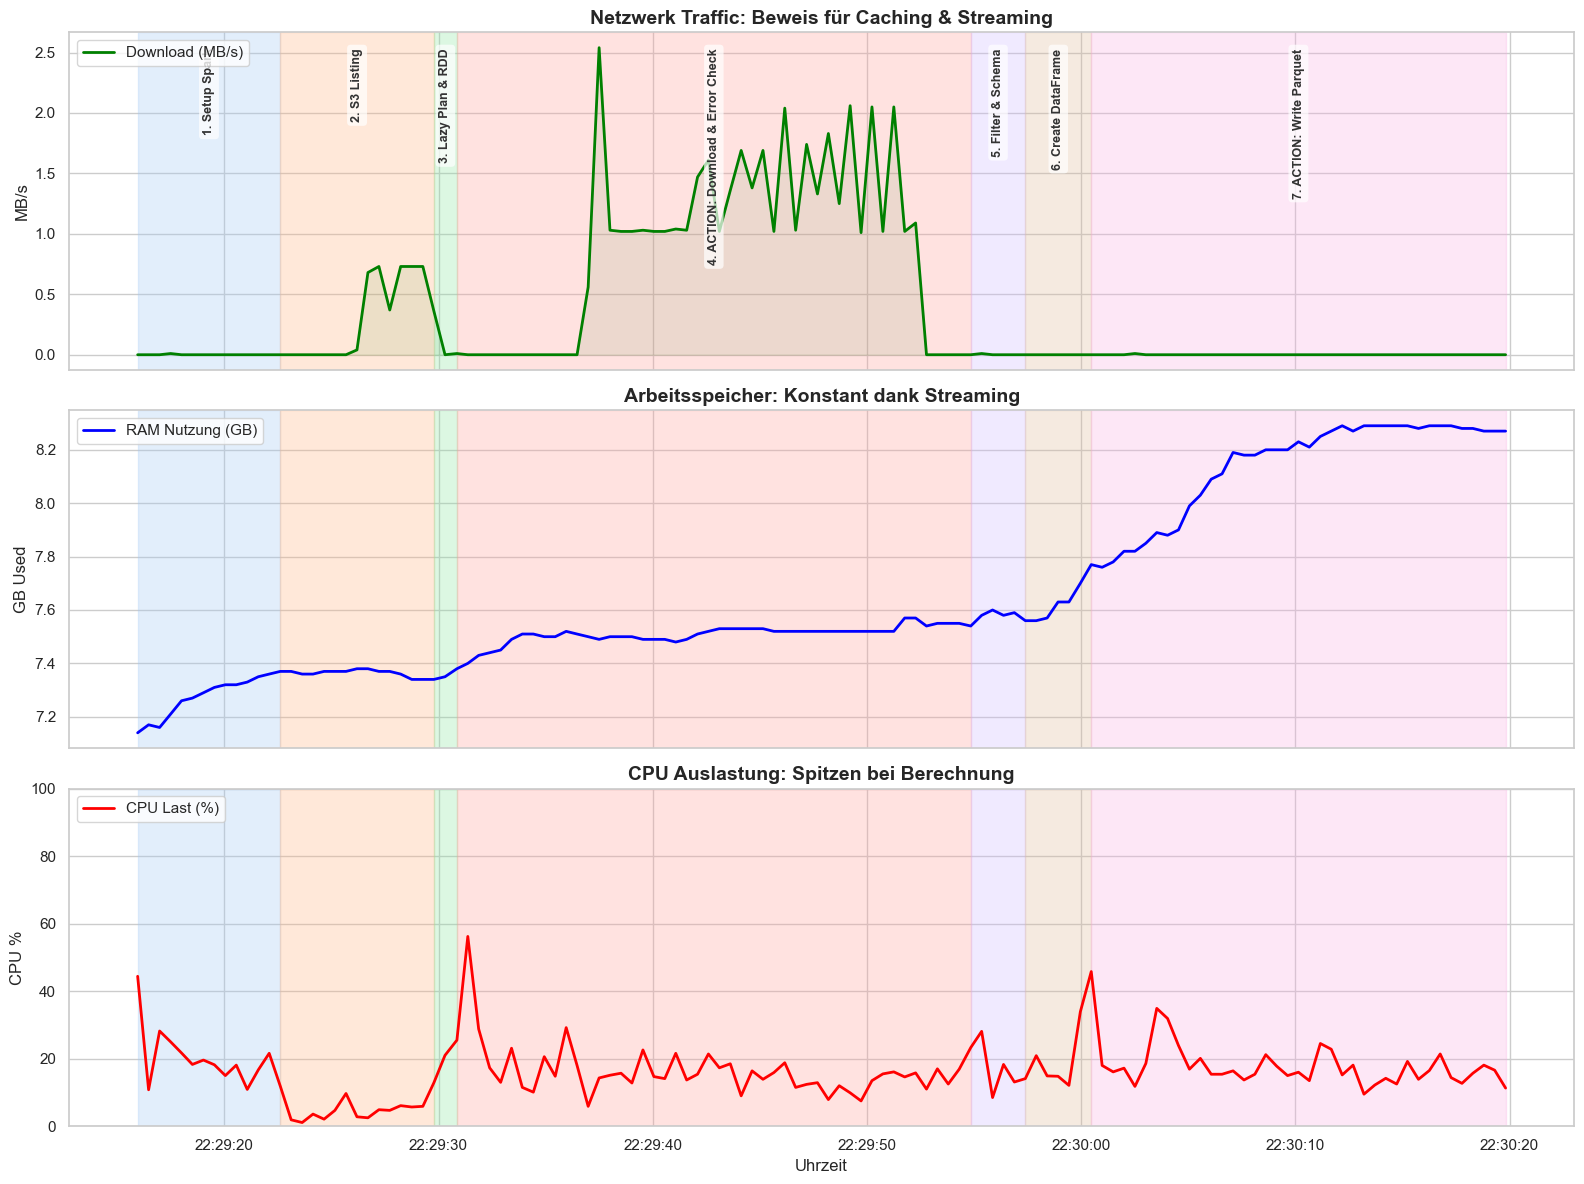

In [3]:
# Setup für 3 Unter-Graphen (Netzwerk, RAM, CPU)
fig, axes = plt.subplots(3, 1, sharex=True)

# ---------------------------------------------------------
# GRAPH 1: NETZWERK (Der Streaming-Beweis)
# ---------------------------------------------------------
sns.lineplot(ax=axes[0], x='timestamp', y='net_recv_mb', data=df,
             color='green', linewidth=2, label='Download (MB/s)')
axes[0].set_title('Netzwerk Traffic: Beweis für Caching & Streaming', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MB/s')
axes[0].fill_between(df['timestamp'], df['net_recv_mb'], color='green', alpha=0.1)
axes[0].legend(loc='upper left')

# ---------------------------------------------------------
# GRAPH 2: RAM (Die Stabilität)
# ---------------------------------------------------------
sns.lineplot(ax=axes[1], x='timestamp', y='ram_gb', data=df,
             color='blue', linewidth=2, label='RAM Nutzung (GB)')
axes[1].set_title('Arbeitsspeicher: Konstant dank Streaming', fontsize=14, fontweight='bold')
axes[1].set_ylabel('GB Used')
axes[1].legend(loc='upper left')

# ---------------------------------------------------------
# GRAPH 3: CPU (Die Verarbeitung)
# ---------------------------------------------------------
sns.lineplot(ax=axes[2], x='timestamp', y='cpu_percent', data=df,
             color='red', linewidth=2, label='CPU Last (%)')
axes[2].set_title('CPU Auslastung: Spitzen bei Berechnung', fontsize=14, fontweight='bold')
axes[2].set_ylabel('CPU %')
axes[2].set_ylim(0, 100)
axes[2].legend(loc='upper left')

# ---------------------------------------------------------
# HINTERGRUND-FARBEN FÜR DIE STAGES
# ---------------------------------------------------------
# Wir färben die Hintergründe basierend auf der Spalte 'stage'
unique_stages = df['stage'].unique()
colors = sns.color_palette("pastel", len(unique_stages))
stage_changes = df.drop_duplicates('stage', keep='first')

for i, (idx, row) in enumerate(stage_changes.iterrows()):
    # Ende der aktuellen Phase bestimmen (Start der nächsten oder Ende der Daten)
    if i + 1 < len(stage_changes):
        next_time = stage_changes.iloc[i+1]['timestamp']
    else:
        next_time = df.iloc[-1]['timestamp']

    for ax in axes:
        # Farbigen Hintergrund zeichnen
        ax.axvspan(row['timestamp'], next_time, color=colors[i], alpha=0.3)

        # Beschriftung nur im oberen Graphen einfügen
        if ax == axes[0]:
            # Mitte der Phase berechnen für Text-Position
            mid_point = row['timestamp'] + (next_time - row['timestamp']) / 2
            ax.text(mid_point, ax.get_ylim()[1]*0.95, row['stage'],
                    ha='center', va='top', rotation=90,
                    fontsize=9, fontweight='bold', color='#333333',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

# ---------------------------------------------------------
# FORMATIERUNG
# ---------------------------------------------------------
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlabel("Uhrzeit")
plt.tight_layout()
plt.show()

In [4]:
# Zusammenfassung berechnen
summary = df.groupby('stage').agg({
    'timestamp': lambda x: (x.max() - x.min()).total_seconds(), # Dauer
    'net_recv_mb': 'sum',   # Gesamter Traffic in dieser Phase
    'cpu_percent': 'mean',  # Durchschn. CPU
    'ram_gb': 'max'         # Max RAM Peak
}).rename(columns={
    'timestamp': 'Dauer (Sek)',
    'net_recv_mb': 'Download Summe (MB)',
    'cpu_percent': 'Ø CPU (%)',
    'ram_gb': 'Max RAM (GB)'
}).sort_values('Dauer (Sek)', ascending=False)

# Tabelle schön anzeigen
print("--- Detaillierte Auswertung pro Phase ---")
display(summary)

--- Detaillierte Auswertung pro Phase ---


,Dauer (Sek),Download Summe (MB),Ø CPU (%),Max RAM (GB)
stage,,,,
4. ACTION: Download & Error Check,23.450018,42.08,16.429787,7.57
7. ACTION: Write Parquet,19.344043,0.01,18.046154,8.29
2. S3 Listing,6.656803,4.01,4.828571,7.38
1. Setup Spark,6.141435,0.01,20.653846,7.36
6. Create DataFrame,2.568452,0.00,18.450000,7.70
5. Filter & Schema,2.035385,0.01,18.260000,7.60
3. Lazy Plan & RDD,0.518367,0.36,16.950000,7.35


## Interpretation der Ergebnisse

1. **Netzwerk (Grüner Graph):** - Man sieht Aktivität NUR in der Phase `4. ACTION: Download`.
   - In der Phase `7. ACTION: Write Parquet` ist die Linie flach bei 0.
   - **Beweis:** Das Caching funktioniert. Spark musste die Daten zum Schreiben nicht neu laden.

2. **RAM (Blauer Graph):**
   - Trotz hohem Download-Traffic bleibt der RAM nahezu konstant (keine riesigen Sprünge).
   - **Beweis:** Das Streaming funktioniert (`yield` + `tarfile stream mode`). Die Datei wird nicht komplett in den Speicher geladen.

3. **CPU (Roter Graph):**
   - Hohe Last beim Schreiben von Parquet (Komprimierung).
   - Moderate Last beim Download (Entpacken von Tar/Avro).


--- DATA PROFILING (Robust) ---
📂 Analysiere Run: run_1769031000
✅ Anzahl Zeilen: 723,098
✅ Anzahl Spalten: 16


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
0,1590364810,7c01c2,-34.505905,149.904243,130.920692,27.370562665503765,0.0,AM217,False,False,False,4067,5791.200000000001,5897.88,1590364798.998,1590364809.802
1,1590364810,a1311e,35.968231,-115.362511,163.201227,203.00887008282288,8.45312,SKW3355,False,False,False,6125,3398.52,3505.20,1590364809.498,1590364809.627
2,1590364810,4afab9,NaN,NaN,NaN,nan,nan,,True,False,False,7777,18288.0,NaN,nan,1590364800.957


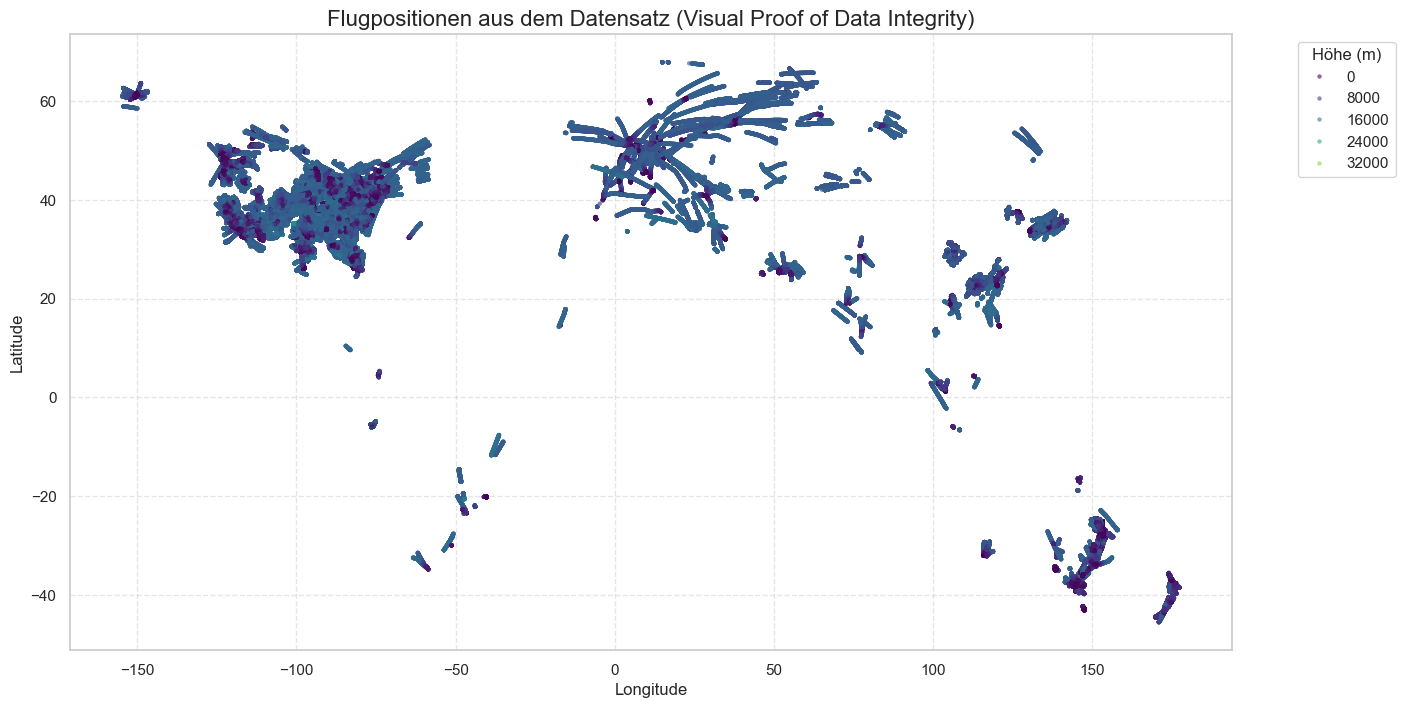

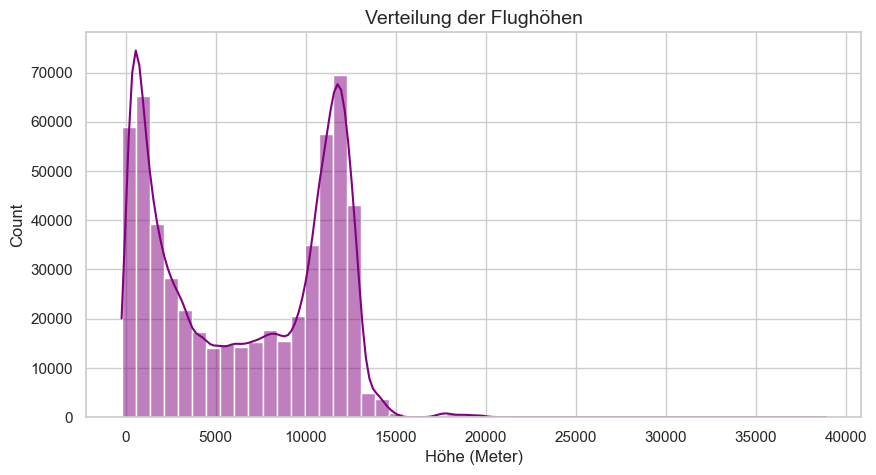

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np # Import für numeric conversion

print("\n--- DATA PROFILING (Robust) ---")

# 1. Pfad-Findung (Sucht intelligent 1 oder 2 Ebenen höher)
possible_paths = [
    "../../data/processed/run_*",  # Wenn Notebook in notebooks/Performance/
    "../data/processed/run_*",     # Wenn Notebook in notebooks/
    "../../src/data/processed/run_*" # Fallback
]

list_of_dirs = []
for p in possible_paths:
    found = glob.glob(p)
    if found:
        list_of_dirs = found
        break

if not list_of_dirs:
    raise ValueError("❌ Keine Daten gefunden. Pfade prüfen!")

# Neuesten Run wählen
latest_run = max(list_of_dirs, key=os.path.getctime)
print(f"📂 Analysiere Run: {os.path.basename(latest_run)}")

# 2. Robustes Laden (Ganzen Ordner lesen, nicht nur die erste Datei!)
try:
    df_data = pd.read_parquet(latest_run)
except:
    # Fallback: Einzelne Dateien sammeln (falls Spark partitioniert hat)
    parquet_files = glob.glob(os.path.join(latest_run, "*.parquet"))
    if not parquet_files:
        raise ValueError("Ordner enthält keine Parquet-Dateien.")
    df_list = [pd.read_parquet(f) for f in parquet_files]
    df_data = pd.concat(df_list, ignore_index=True)

print(f"✅ Anzahl Zeilen: {len(df_data):,}")
print(f"✅ Anzahl Spalten: {len(df_data.columns)}")

# WICHTIG: Datentypen für Plotting konvertieren (String -> Float)
numeric_cols = ['lat', 'lon', 'geoaltitude']
for c in numeric_cols:
    if c in df_data.columns:
        df_data[c] = pd.to_numeric(df_data[c], errors='coerce')

display(df_data.head(3))

# 3. Visualisierung: Weltkarte
if len(df_data) > 0 and 'lat' in df_data.columns:
    plt.figure(figsize=(15, 8))
    sns.scatterplot(
        x='lon',
        y='lat',
        data=df_data,
        hue='geoaltitude', # Farbe nach Höhe
        palette='viridis',
        s=10,
        alpha=0.6,
        linewidth=0
    )
    plt.title(f'Flugpositionen aus dem Datensatz (Visual Proof of Data Integrity)', fontsize=16)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Höhe (m)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("⚠️ Keine Geodaten für die Karte vorhanden.")

# 4. Histogramm
if len(df_data) > 0 and 'geoaltitude' in df_data.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_data['geoaltitude'].dropna(), bins=50, kde=True, color='purple')
    plt.title('Verteilung der Flughöhen', fontsize=14)
    plt.xlabel('Höhe (Meter)')
    plt.show()